In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
#load data and labels
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
train_csv = os.path.join(data_dir, 'train.csv')

#load train.csv
label_map_path = os.path.join(data_dir, 'label_num_to_phase_map.json')
label_map = pd.read_json(label_map_path, typ='series').to_dict()
inv_label_map = {v: k for k, v in label_map.items()}
train_df = pd.read_csv(train_csv)
train_df['filepath'] = train_df['image_id'].apply(lambda x: os.path.join(train_dir, x))

In [3]:
#load model and extract from intermediate layer
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
mid_layer = 'block3a_expand_activation'
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer(mid_layer).output)
feature_model.trainable = False

In [4]:
#extract features
def extract_features(filepaths):
    features = []
    for path in filepaths:
        img = load_img(path, target_size=(224, 224))
        img_array = preprocess_input(img_to_array(img))
        img_batch = np.expand_dims(img_array, axis=0)
        feat = feature_model.predict(img_batch, verbose=0).flatten()
        features.append(feat)
    return np.array(features)

In [5]:
#split train/val to evaluate model
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_df['filepath'], train_df['label'], test_size=0.2, stratify=train_df['label'], random_state=42)

In [6]:
#extract features
X_train_feat = extract_features(X_train_split)
X_val_feat = extract_features(X_val_split)

In [7]:
#train and change classifier
clf = LogisticRegression(max_iter=1000)
# clf = SVC(kernel='rbf', probability=True)
# clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train_feat, y_train_split)

LogisticRegression(max_iter=1000)

In [8]:
#validation
val_preds = clf.predict(X_val_feat)
val_acc = accuracy_score(y_val_split, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.6566


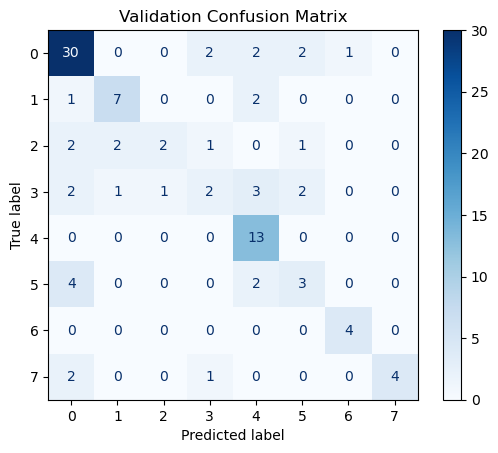

In [9]:
#confusion matrix
cm = confusion_matrix(y_val_split, val_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

In [10]:
#inference on test set (no labels)
test_filenames = sorted(os.listdir(test_dir))
test_paths = [os.path.join(test_dir, fname) for fname in test_filenames]
test_features = extract_features(test_paths)
test_preds = clf.predict(test_features)

In [11]:
#save predictions
pred_df = pd.DataFrame({
    'image_id': test_filenames,
    'predicted_label': test_preds
})
pred_df.to_csv('predicted_test_labels.csv', index=False)
print("Saved predicted_test_labels.csv")


Saved predicted_test_labels.csv


In [12]:
#fine tuning
#try pulling from previous layers
#try different cnns